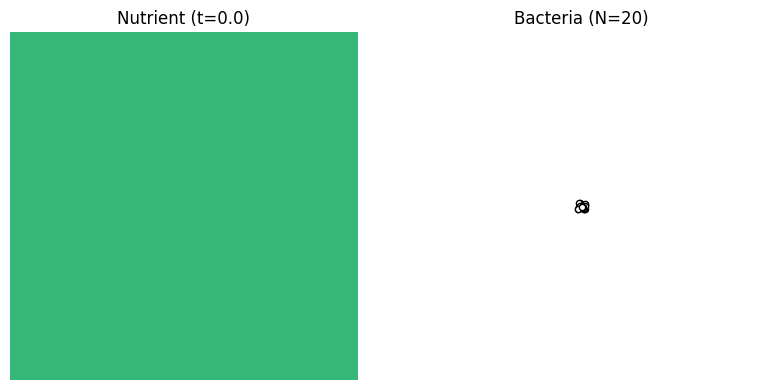

: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
import threading
import queue

# ------------ Simulation classes ------------
class Bacterium:
    def __init__(self, position):
        self.pos = np.array(position, dtype=float)
        self.initial_pos = np.array(position, dtype=float)

    def move(self, step_size, grid_shape):
        dy, dx = np.random.normal(0, step_size, size=2)
        new_y, new_x = self.pos[0] + dy, self.pos[1] + dx
        ny, nx = grid_shape
        # Reflect boundaries
        if new_y < 0: new_y = -new_y
        if new_y >= ny: new_y = 2*(ny - 1) - new_y
        if new_x < 0: new_x = -new_x
        if new_x >= nx: new_x = 2*(nx - 1) - new_x
        self.pos = np.array([new_y, new_x])

    def get_msd(self):
        return np.sum((self.pos - self.initial_pos)**2)

class BacterialGrowthSim:
    def __init__(self, params):
        self.N = int(params['grid_size'])
        self.dx = 1.0
        self.dt = params['dt']

        self.D = params['D']
        self.r = params['r']
        self.K = int(params['K'])
        self.Ks = params['Ks']
        self.death_rate = params['death_rate']
        self.beta = params['beta']
        self.step_size = params['step_size']

        # Nutrient field
        self.C = np.ones((self.N, self.N)) * params['init_nut']

        # Place bacteria at center with jitter
        center = (self.N - 1) / 2
        self.bacteria = []
        for _ in range(int(params['init_bac'])):
            y0 = center + np.random.uniform(-1, 1)
            x0 = center + np.random.uniform(-1, 1)
            self.bacteria.append(Bacterium([y0, x0]))

        self.alpha = (self.D * self.dt) / (self.dx**2)
        self.time = 0.0
        self.history_pop = []
        self.history_msd = []
        self.history_avg_nutrient = []

    def laplacian(self, A):
        lap = np.zeros_like(A)
        N = self.N
        lap[1:-1, 1:-1] = (
            A[0:-2, 1:-1] + A[2:, 1:-1] +
            A[1:-1, 0:-2] + A[1:-1, 2:] -
            4 * A[1:-1, 1:-1]
        )
        # Edges reflect
        lap[0, 1:-1] = (A[1, 1:-1] + A[0, 2:] + A[0, 0:-2] + A[1, 1:-1] - 4*A[0, 1:-1])
        lap[-1, 1:-1] = (A[-2, 1:-1] + A[-1, 2:] + A[-1, 0:-2] + A[-2, 1:-1] - 4*A[-1, 1:-1])
        lap[1:-1, 0] = (A[0:-2, 0] + A[2:, 0] + A[1:-1, 1] + A[1:-1, 1] - 4*A[1:-1, 0])
        lap[1:-1, -1] = (A[0:-2, -1] + A[2:, -1] + A[1:-1, -2] + A[1:-1, -2] - 4*A[1:-1, -1])
        lap[0, 0] = (A[1, 0] + A[0, 1] + A[1, 0] + A[0, 1] - 4*A[0, 0])
        lap[0, -1] = (A[1, -1] + A[0, -2] + A[1, -1] + A[0, -2] - 4*A[0, -1])
        lap[-1, 0] = (A[-2, 0] + A[-1, 1] + A[-2, 0] + A[-1, 1] - 4*A[-1, 0])
        lap[-1, -1] = (A[-2, -1] + A[-1, -2] + A[-2, -1] + A[-1, -2] - 4*A[-1, -1])
        return lap

    def diffuse_nutrient(self):
        L = self.laplacian(self.C)
        self.C += self.alpha * L
        np.clip(self.C, 0.0, None, out=self.C)

    def bacteria_actions(self):
        new_bac = []
        N_pop = len(self.bacteria)
        for b in self.bacteria:
            b.move(self.step_size, (self.N, self.N))
            yi, xi = int(round(b.pos[0])), int(round(b.pos[1]))
            yi = np.clip(yi, 0, self.N - 1)
            xi = np.clip(xi, 0, self.N - 1)
            self.C[yi, xi] = max(self.C[yi, xi] - self.beta * self.dt, 0.0)

            C_local = self.C[yi, xi]
            Pgrow = self.r * N_pop * (1 - N_pop/self.K) * (C_local/(C_local + self.Ks))
            p_per_bac = Pgrow * self.dt / max(N_pop, 1)
            if np.random.rand() < p_per_bac:
                new_bac.append(Bacterium(b.pos.copy()))

            if np.random.rand() < (self.death_rate * self.dt):
                continue
            else:
                new_bac.append(b)

        self.bacteria = new_bac

    def step(self):
        self.diffuse_nutrient()
        self.bacteria_actions()
        self.time += self.dt
        pop = len(self.bacteria)
        self.history_pop.append(pop)
        self.history_avg_nutrient.append(np.mean(self.C))
        if pop > 0:
            msd_val = np.mean([b.get_msd() for b in self.bacteria])
        else:
            msd_val = 0.0
        self.history_msd.append(msd_val)

# ------------ GUI Application ------------
class BacterialApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Bacterial Growth Simulation")

        # Parameter defaults
        self.params = {
            'grid_size': 100,
            'dt': 0.1,
            'D': 1.0,
            'r': 0.5,
            'K': 200,
            'Ks': 0.5,
            'death_rate': 0.01,
            'beta': 1.0,
            'step_size': 0.5,
            'init_bac': 20,
            'init_nut': 1.0
        }

        # Top frame for controls
        ctrl_frame = tk.Frame(root)
        ctrl_frame.pack(side=tk.TOP, fill=tk.X)

        # Create sliders in two rows
        row1 = tk.Frame(ctrl_frame)
        row1.pack(side=tk.TOP, fill=tk.X)
        row2 = tk.Frame(ctrl_frame)
        row2.pack(side=tk.TOP, fill=tk.X)

        # First row of sliders
        self.sliders = {}
        specs1 = [
            ('grid_size', 'Grid N', 50, 200, 25),
            ('dt', 'dt', 0.01, 0.5, 0.01),
            ('D', 'Diffusion D', 0.1, 5.0, 0.1),
            ('r', 'Growth r', 0.1, 2.0, 0.1),
            ('K', 'Cap K', 50, 500, 50)
        ]
        for (key, label, lo, hi, step) in specs1:
            scale = tk.Scale(row1, label=label, from_=lo, to=hi, resolution=step, orient='horizontal', length=150)
            scale.set(self.params[key])
            scale.pack(side=tk.LEFT, padx=5, pady=5)
            self.sliders[key] = scale

        # Second row of sliders
        specs2 = [
            ('Ks', 'Half‐sat Ks', 0.1, 5.0, 0.1),
            ('death_rate', 'Death γ', 0.001, 0.1, 0.001),
            ('beta', 'Consume β', 0.1, 5.0, 0.1),
            ('step_size', 'Step σ', 0.1, 2.0, 0.1),
            ('init_bac', 'Init Bacteria', 1, 100, 1),
            ('init_nut', 'Init Nutrient', 0.5, 5.0, 0.1)
        ]
        for (key, label, lo, hi, step) in specs2:
            scale = tk.Scale(row2, label=label, from_=lo, to=hi, resolution=step, orient='horizontal', length=120)
            scale.set(self.params[key])
            scale.pack(side=tk.LEFT, padx=5, pady=5)
            self.sliders[key] = scale

        # Buttons and additional controls row
        btn_frame = tk.Frame(ctrl_frame)
        btn_frame.pack(side=tk.TOP, pady=5)

        self.start_btn = tk.Button(btn_frame, text="Start", command=self.start)
        self.start_btn.pack(side=tk.LEFT, padx=5)

        self.pause_btn = tk.Button(btn_frame, text="Pause", command=self.pause)
        self.pause_btn.pack(side=tk.LEFT, padx=5)

        self.reset_btn = tk.Button(btn_frame, text="Reset", command=self.reset)
        self.reset_btn.pack(side=tk.LEFT, padx=5)

        tk.Label(btn_frame, text="MC runs:").pack(side=tk.LEFT, padx=5)
        self.mc_runs_slider = tk.Scale(btn_frame, from_=1, to=50, resolution=1, orient='horizontal', length=100)
        self.mc_runs_slider.set(10)
        self.mc_runs_slider.pack(side=tk.LEFT, padx=5)

        self.mc_btn = tk.Button(btn_frame, text="Run MC", command=self.run_monte_carlo)
        self.mc_btn.pack(side=tk.LEFT, padx=5)

        self.help_btn = tk.Button(btn_frame, text="Help", command=self.show_help)
        self.help_btn.pack(side=tk.LEFT, padx=5)

        # Figure for plots
        self.fig, (self.ax_nutr, self.ax_bac) = plt.subplots(1, 2, figsize=(8, 4))
        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=1)

        self.running = False
        self.sim = None
        self.im_nutr = None
        self.sc_bac = None

        self.reset()

    def read_params(self):
        for key, scale in self.sliders.items():
            val = scale.get()
            if key in ['grid_size', 'K', 'init_bac']:
                self.params[key] = int(val)
            else:
                self.params[key] = float(val)

    def reset(self):
        self.running = False
        self.read_params()
        self.sim = BacterialGrowthSim(self.params)

        # Clear axes
        self.ax_nutr.clear()
        self.ax_bac.clear()

        # Initial nutrient heatmap (origin='lower' to match scatter)
        self.im_nutr = self.ax_nutr.imshow(self.sim.C, cmap='viridis',
                                           vmin=0, vmax=np.max(self.sim.C)+0.5,
                                           origin='lower')
        self.ax_nutr.set_title("Nutrient (t=0.0)")
        self.ax_nutr.axis('off')

        # Initial bacteria scatter
        pos = np.array([b.pos for b in self.sim.bacteria])
        if pos.size == 0:
            pos = np.empty((0, 2))
        self.sc_bac = self.ax_bac.scatter(pos[:,1], pos[:,0],
                                          c='white', s=20, edgecolors='black')
        self.ax_bac.set_xlim(0, self.sim.N-1)
        self.ax_bac.set_ylim(0, self.sim.N-1)
        self.ax_bac.set_title(f"Bacteria (N={len(self.sim.bacteria)})")
        self.ax_bac.axis('off')

        self.fig.tight_layout()
        self.canvas.draw()

    def update(self):
        if not self.running:
            return

        self.sim.step()

        # Update nutrient heatmap
        self.im_nutr.set_data(self.sim.C)
        self.im_nutr.set_clim(0, np.max(self.sim.C)+0.5)
        self.ax_nutr.set_title(f"Nutrient (t={self.sim.time:.1f})")

        # Update bacteria scatter
        pos = np.array([b.pos for b in self.sim.bacteria])
        if pos.size == 0:
            self.sc_bac.set_offsets(np.empty((0,2)))
        else:
            self.sc_bac.set_offsets(np.column_stack((pos[:,1], pos[:,0])))
        self.ax_bac.set_title(f"Bacteria (N={len(self.sim.bacteria)})")

        self.canvas.draw()
        delay = int(self.sim.dt * 1000)
        self.root.after(delay, self.update)

    def start(self):
        if not self.running:
            self.running = True
            self.update()

    def pause(self):
        self.running = False

    def show_help(self):
        help_win = tk.Toplevel(self.root)
        help_win.title("Parameter Explanations")
        text = (
            "Grid N: Size of the square grid (NxN).\n"
            "dt: Time step for simulation (smaller → more accurate but slower).\n"
            "Diffusion D: Coefficient for nutrient diffusion.\n"
            "Growth r: Intrinsic growth rate in logistic term.\n"
            "Cap K: Carrying capacity for bacteria population.\n"
            "Half-sat Ks: Saturation constant in nutrient-limited growth.\n"
            "Death γ: Death probability per unit time.\n"
            "Consume β: Amount of nutrient consumed per bacterium per time step.\n"
            "Step σ: Standard deviation of random-walk step for bacteria.\n"
            "Init Bacteria: Number of bacteria initially (center of grid).\n"
            "Init Nutrient: Initial uniform nutrient concentration.\n"
            "MC runs: Number of Monte Carlo simulations to average over.\n"
            "\nError Analysis (Monte Carlo):\n"
            "Runs multiple independent simulations with same parameters,\n"
            "computes mean and std of population over time.\n"
        )
        tk.Label(help_win, text=text, justify=tk.LEFT).pack(padx=10, pady=10)

    def run_monte_carlo(self):
        runs = int(self.mc_runs_slider.get())
        self.start_btn.config(state=tk.DISABLED)
        self.pause_btn.config(state=tk.DISABLED)
        self.reset_btn.config(state=tk.DISABLED)
        self.mc_btn.config(state=tk.DISABLED)

        # Create a queue for passing data to main thread
        data_queue = queue.Queue()

        def mc_task():
            max_steps = int(50 / self.params['dt'])
            all_pops = np.zeros((runs, max_steps))
            for i in range(runs):
                sim = BacterialGrowthSim(self.params)
                for t in range(max_steps):
                    sim.step()
                    all_pops[i, t] = len(sim.bacteria)
            mean_pop = np.mean(all_pops, axis=0)
            std_pop = np.std(all_pops, axis=0)
            times = np.arange(max_steps) * self.params['dt']
            
            # Put the data in the queue
            data_queue.put((times, mean_pop, std_pop))

        def plot_results():
            try:
                times, mean_pop, std_pop = data_queue.get_nowait()
                
                # Create new window for Monte Carlo results
                mc_window = tk.Toplevel(self.root)
                mc_window.title(f"Monte Carlo Results ({runs} runs)")
                
                # Create figure and canvas
                fig = plt.Figure(figsize=(6, 4))
                canvas = FigureCanvasTkAgg(fig, master=mc_window)
                canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
                
                # Create plot
                ax = fig.add_subplot(111)
                ax.plot(times, mean_pop, '-k', label='Mean Population')
                ax.fill_between(times, mean_pop-std_pop, mean_pop+std_pop, 
                              color='gray', alpha=0.5, label='±1 std')
                ax.set_xlabel("Time")
                ax.set_ylabel("Population")
                ax.set_title(f"Monte Carlo ({runs} runs)")
                ax.legend()
                
                fig.tight_layout()
                canvas.draw()

                # Re-enable buttons
                self.start_btn.config(state=tk.NORMAL)
                self.pause_btn.config(state=tk.NORMAL)
                self.reset_btn.config(state=tk.NORMAL)
                self.mc_btn.config(state=tk.NORMAL)
            except queue.Empty:
                # If data isn't ready yet, try again in 100ms
                self.root.after(100, plot_results)

        # Start the Monte Carlo simulation in a separate thread
        threading.Thread(target=mc_task).start()
        # Start checking for results in the main thread
        self.root.after(100, plot_results)

# Run the application
if __name__ == '__main__':
    root = tk.Tk()
    app = BacterialApp(root)
    root.mainloop()
